## 1. Inicialización

In [ ]:
#importar librerías
import pandas as pd
import matplotlib as plt
from sklearn.metrics import mean_absolute_error
import numpy as np

## 1.1 Cargar datos

In [2]:
#cargar datasets
df_full = pd.read_csv('files/data gold/gold_recovery_full.csv')
df_test = pd.read_csv('files/data gold/gold_recovery_test.csv')
df_train = pd.read_csv('files/data gold/gold_recovery_train.csv')

## 1.2. Comprobar el cálculo de la recuperación de oro en el conjunto de entrenamiento

In [3]:
#función para comprobar el cálculo del recovery
def recovery(row):
    numerator = row['rougher.output.concentrate_au'] * (row['rougher.input.feed_au'] - row['rougher.output.tail_au'])
    denominator = row['rougher.input.feed_au'] * (row['rougher.output.concentrate_au'] - row['rougher.output.tail_au'])
    
    recovery = numerator / denominator * 100
    
    return recovery

In [4]:
#caluclar el recovery con la función
function_recovery = recovery(df_train)

#seleccionar los valores mayores que 0
function_recovery= function_recovery[function_recovery > 0]

#comprobar valor mínimo y máximo
print(function_recovery.min())
print(function_recovery.max())

1.0757503319071937
inf


Luego de calcular la recuperación del oro utilizando la función, obtengo valores de infinito positivo y me causa problemas para calcular el error absoluto medio de comparación con el recovery original del dataframe. Por lo tanto, voy a reemplazar los infinitos por valores ausentes y luegos los voy a eliminar.

In [5]:
#crear un dataframe con el recovery de la funcion y el original

au_recovery = pd.DataFrame({'function_recovery': function_recovery, 'original_recovery': df_train['rougher.output.recovery']})

#reemplazar los valores infinitos por nans
au_recovery = au_recovery.replace([np.inf], np.nan)

#quitar valores ausentes
au_recovery = au_recovery.dropna()

#calcular el error absoluto medio de ambos recoveries
eam = mean_absolute_error(au_recovery['original_recovery'], au_recovery['function_recovery'])

print('Error absoluto medio del recovery:', eam)

Error absoluto medio del recovery: 9.516567545612377e-15


El EAM que resultó del cálculo manual de la recuperación del oro es bastante bajo, por lo tanto, significa que los cálculos del recovery en el dataframe original son confiables.

## 1.3. Características no disponibles en el conjunto de prueba

In [6]:
#analizar las columnas faltantes en df_test 
missed_test_columns = set(list(df_train.columns.values)) - set(list(df_test.columns.values))

missed_test_columns

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

Al analizar las columnas faltantes en el dataset de prueba, puedo darme cuenta de que las columnas faltantes corresponden a los resultados finales de los procesos. Por lo tanto, este dataset es el indicado para la prueba final del modelo de predicción.

## 1.4. Preprocesamiento de datos

### 1.4.1. Preparar dataset completo

In [7]:
#visualizar datos 
df_full.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [8]:
#ver información general del dataset 
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


Lo tipos de datos parecen correctos, excepto en la columna 'date' correspondiente a las fechas, que tiene un tipo de datos 'object', sin embargo, esta columna no parece necesaria para realizar cálculos en el dataset. En un principio la mantendré como está.

In [9]:
#verificar datos ausentes
df_full.isna().sum()

date                                            0
final.output.concentrate_ag                    89
final.output.concentrate_pb                    87
final.output.concentrate_sol                  385
final.output.concentrate_au                    86
                                             ... 
secondary_cleaner.state.floatbank5_a_level    101
secondary_cleaner.state.floatbank5_b_air      101
secondary_cleaner.state.floatbank5_b_level    100
secondary_cleaner.state.floatbank6_a_air      119
secondary_cleaner.state.floatbank6_a_level    101
Length: 87, dtype: int64

En las 87 columnas hay datos ausentes. En lugar de eliminarlos, voy a utilizar el método 'ffill', para rellenar cada dato ausente con la fecha y hora anteriores más próximos.

In [10]:
#rellenar los datos ausentes con ffill
df_full = df_full.ffill()

#verificar nuevamente datos ausentes
df_full.isna().sum()

date                                          0
final.output.concentrate_ag                   0
final.output.concentrate_pb                   0
final.output.concentrate_sol                  0
final.output.concentrate_au                   0
                                             ..
secondary_cleaner.state.floatbank5_a_level    0
secondary_cleaner.state.floatbank5_b_air      0
secondary_cleaner.state.floatbank5_b_level    0
secondary_cleaner.state.floatbank6_a_air      0
secondary_cleaner.state.floatbank6_a_level    0
Length: 87, dtype: int64

In [11]:
#verificar valores duplicados
df_full.duplicated().sum()

0

No hay valores duplicados en las filas completas de este dataset, de modo que ya se encuentran listos estos datos para comenzar a trabajar con ellos.

### 1.4.2. Preparar dataset de prueba

In [12]:
#visualizar los datos
df_test.head()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


In [13]:
#ver informacion general 
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

Lo tipos de datos parecen correctos, excepto en la columna 'date' correspondiente a las fechas, que tiene un tipo de datos 'object', sin embargo, esta columna no parece necesaria para realizar cálculos en el dataset. En un principio la mantendré como está.

In [14]:
#verificar valores ausentes
df_test.isna().sum()

date                                            0
primary_cleaner.input.sulfate                 302
primary_cleaner.input.depressant              284
primary_cleaner.input.feed_size                 0
primary_cleaner.input.xanthate                166
primary_cleaner.state.floatbank8_a_air         16
primary_cleaner.state.floatbank8_a_level       16
primary_cleaner.state.floatbank8_b_air         16
primary_cleaner.state.floatbank8_b_level       16
primary_cleaner.state.floatbank8_c_air         16
primary_cleaner.state.floatbank8_c_level       16
primary_cleaner.state.floatbank8_d_air         16
primary_cleaner.state.floatbank8_d_level       16
rougher.input.feed_ag                          16
rougher.input.feed_pb                          16
rougher.input.feed_rate                        40
rougher.input.feed_size                        22
rougher.input.feed_sol                         67
rougher.input.feed_au                          16
rougher.input.floatbank10_sulfate             257


En varias de las columnas se encontraron valores ausentes. En lugar de eliminarlos, voy a utilizar el método 'ffill', para rellenar cada dato ausente con la fecha y hora anteriores más próximos.

In [15]:
#rellenar los valores ausentes 
df_test = df_test.ffill()

#verificar nuevamente los valores ausentes
df_test.isna().sum()

date                                          0
primary_cleaner.input.sulfate                 0
primary_cleaner.input.depressant              0
primary_cleaner.input.feed_size               0
primary_cleaner.input.xanthate                0
primary_cleaner.state.floatbank8_a_air        0
primary_cleaner.state.floatbank8_a_level      0
primary_cleaner.state.floatbank8_b_air        0
primary_cleaner.state.floatbank8_b_level      0
primary_cleaner.state.floatbank8_c_air        0
primary_cleaner.state.floatbank8_c_level      0
primary_cleaner.state.floatbank8_d_air        0
primary_cleaner.state.floatbank8_d_level      0
rougher.input.feed_ag                         0
rougher.input.feed_pb                         0
rougher.input.feed_rate                       0
rougher.input.feed_size                       0
rougher.input.feed_sol                        0
rougher.input.feed_au                         0
rougher.input.floatbank10_sulfate             0
rougher.input.floatbank10_xanthate      

In [16]:
#verificar valores duplicados
df_test.duplicated().sum()

0

Tenemos un dataset de prueba con menor número de columnas que el dataset de entrenamiento, porque justamente faltan las columnas que contienen los datos sobre los resultados finales de todos los procesos. 

En este conjunto de datos no se hallaron valores duplicados y, una vez que se han rellenado los valores ausentes y los tipos de datos son correctos, está listo para ser utilizado.

### 1.4.3. Preparar dataset de entrenamiento

In [17]:
#visualizar los datos
df_train.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [18]:
#ver info general
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


Encontré tipos de datos correctos a excepción de la columna correspondientes a la fecha y hora. Sin embargo, por el momento la mantendré como está pues no creo que sea necesario cambiar a tipo date-time.

In [19]:
#verificar valores ausentes 
df_train.isna().sum()

date                                            0
final.output.concentrate_ag                    72
final.output.concentrate_pb                    72
final.output.concentrate_sol                  370
final.output.concentrate_au                    71
                                             ... 
secondary_cleaner.state.floatbank5_a_level     85
secondary_cleaner.state.floatbank5_b_air       85
secondary_cleaner.state.floatbank5_b_level     84
secondary_cleaner.state.floatbank6_a_air      103
secondary_cleaner.state.floatbank6_a_level     85
Length: 87, dtype: int64

Encontré valores ausentes en muchas de las columnas. Procederé a rellenar con los valores de fecha y hora más próximos, utilizando 'ffill'..

In [20]:
#rellenanar valores ausentes
df_train = df_train.ffill()

#verificando nuevamente valores ausentes
df_train.isna().sum()

date                                          0
final.output.concentrate_ag                   0
final.output.concentrate_pb                   0
final.output.concentrate_sol                  0
final.output.concentrate_au                   0
                                             ..
secondary_cleaner.state.floatbank5_a_level    0
secondary_cleaner.state.floatbank5_b_air      0
secondary_cleaner.state.floatbank5_b_level    0
secondary_cleaner.state.floatbank6_a_air      0
secondary_cleaner.state.floatbank6_a_level    0
Length: 87, dtype: int64

In [21]:
#verificar valores duplicados
df_train.duplicated().sum()

0

Tenemos un dataset de entrenamiento que contiene todas las columnas disponibles en el datatset completo, pero con menor cantidad de filas. En este dataset se encuentran  los targets y las características para entrenar al modelo, que luego pondremos a prueba con el dataset de prueba. 
Aqui no se encontraron valores duplicados. 

Ya se encuentran los tres conjuntos de datos preparados para proseguir con el análisis. 

## 2.  2.1. Concentración de metales (Au, Ag, Pb) en función de la etapa de purificación

### 2.  2.1.  1. Concentración de oro

array([[<Axes: title={'center': 'Materia prima del oro'}>,
        <Axes: title={'center': 'Concentrado luego de la flotación'}>],
       [<Axes: title={'center': 'Concentrado luego de limpieza primaria'}>,
        <Axes: title={'center': 'Concentrado luego de limpieza secundaria'}>]],
      dtype=object)

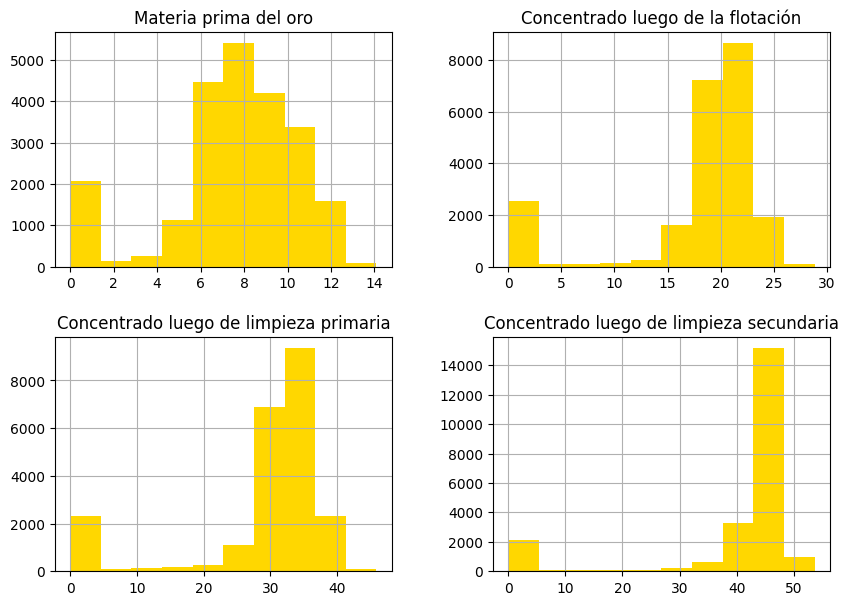

In [78]:
#concentrado de oro en todas las etapas de purificacion
concentrate_stages_au = pd.DataFrame({
    'Materia prima del oro': df_full['rougher.input.feed_au'],
    'Concentrado luego de la flotación': df_full['rougher.output.concentrate_au'], 
    'Concentrado luego de limpieza primaria': df_full['primary_cleaner.output.concentrate_au'], 
    'Concentrado luego de limpieza secundaria': df_full['final.output.concentrate_au']
    })
  
#hacer un histograma para ver la concentracion del oro
concentrate_stages_au.hist(color='gold', figsize= [10,7])


Mediante un histograma se puede observar la concentración del oro en distintas etapas de purificación.

La primera etapa corresponde a la concentración de oro en estado de materia prima aún sin procesar y se puede apreciar una baja concentración del metal. A continuación, vemos que luego de la etapa de flotación, la materia prima se reduce pero aumenta la concentración del metal que nos interesa. Al seguir analizando, veo que luego de la primera y segunda limpieza, se reduce considerablemente la materia prima mientras que la concentración del oro aumenta un poco más del doble de lo que se veía al principio. El aumento de la concentración del oro es progresivo en cada una de las etapas de purificación.

### 2.  2.1.  2. Concentración de plomo

array([[<Axes: title={'center': 'Materia prima del plomo'}>,
        <Axes: title={'center': 'Concentrado luego de la flotación'}>],
       [<Axes: title={'center': 'Concentrado luego de limpieza primaria'}>,
        <Axes: title={'center': 'Concentrado luego de limpieza secundaria'}>]],
      dtype=object)

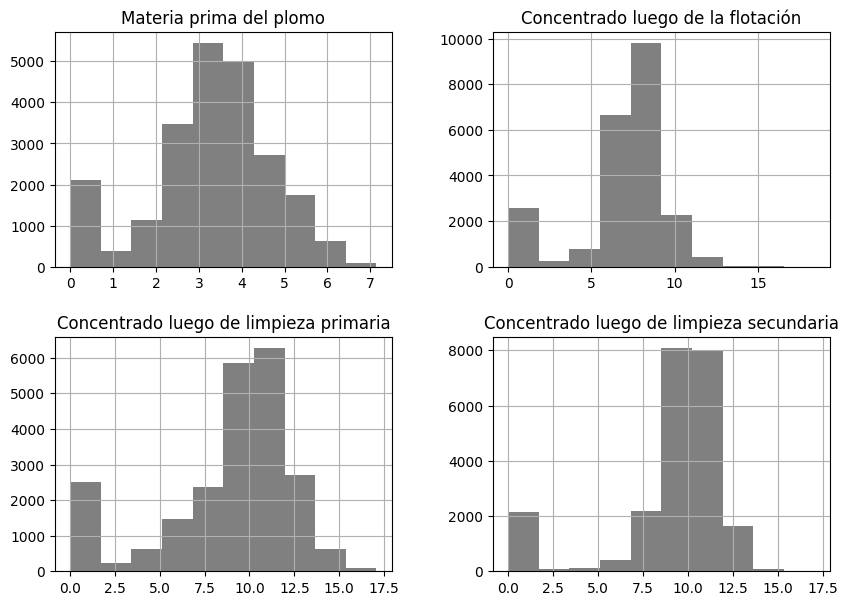

In [72]:
#concentrado de plomo en todas las etapas de purificacion
concentrate_stages_pb = pd.DataFrame({
    'Materia prima del plomo': df_full['rougher.input.feed_pb'],
    'Concentrado luego de la flotación': df_full['rougher.output.concentrate_pb'], 
    'Concentrado luego de limpieza primaria': df_full['primary_cleaner.output.concentrate_pb'], 
    'Concentrado luego de limpieza secundaria': df_full['final.output.concentrate_pb']
    })
  
#hacer un histograma para ver la concentracion del plomo 
concentrate_stages_pb.hist(color='gray', figsize= [10,7])



Mediante estos histogramas, puedo observar algo interesante: luego de la etapa de flotación la concentración de plomo disminuye, para luego aumentar nuevamente en la concentración final luego de limpieza primaria.

### 2.  2.1.  3. Concentración de plata

array([[<Axes: title={'center': 'Materia prima de la plata'}>,
        <Axes: title={'center': 'Concentrado luego de la flotación'}>],
       [<Axes: title={'center': 'Concentrado luego de limpieza primaria'}>,
        <Axes: title={'center': 'Concentrado luego de limpieza secundaria'}>]],
      dtype=object)

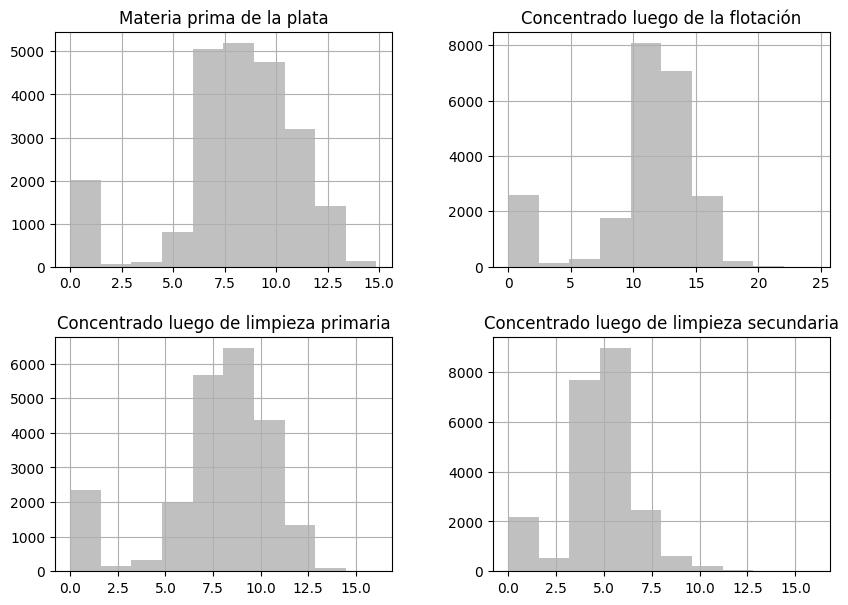

In [73]:
#concentrado de plata en todas las etapas de purificacion
concentrate_stages_ag = pd.DataFrame({
    'Materia prima de la plata': df_full['rougher.input.feed_ag'],
    'Concentrado luego de la flotación': df_full['rougher.output.concentrate_ag'], 
    'Concentrado luego de limpieza primaria': df_full['primary_cleaner.output.concentrate_ag'], 
    'Concentrado luego de limpieza secundaria': df_full['final.output.concentrate_ag']
    })
  
#hacer un histograma para ver la concentracion de la plata 
concentrate_stages_ag.hist(color='silver', figsize= [10,7])



En los caso del plomo y la plata, se observó un aumento discontinuo de la concentración de los metales, es decir, luego del proceso de flotación la concentración disminuye y luego aumenta nuevamente luego de la limpieza primaria. En estos ambos casos, se puede observar que la concentración aumenta cuando pasamos de una etapa de materia prima a una etapa de limpieza secundaria. Sin embargo, en el caso del oro, el aumento observado a través de todas la etapas de purificación es significativamente más alto, más del doble de lo que se puede observar en la etapa inicial.

### 2.  2.2. Compara las distribuciones del tamaño de las partículas de la alimentación en el conjunto de entrenamiento y en el conjunto de prueba. Si las distribuciones varían significativamente, la evaluación del modelo no será correcta.

### 2.  2.2.  1. Alimentación del oro

array([[<Axes: title={'center': 'Feed oro conjunto de entrenamiento'}>,
        <Axes: title={'center': 'Feed oro conjunto de prueba'}>]],
      dtype=object)

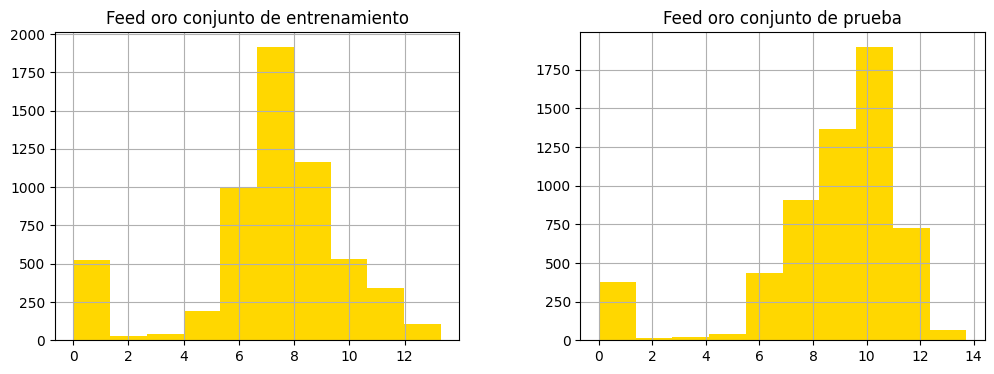

In [103]:
#crear un dataframe con las partículas de alimentacion en conjunto de entrenamiento y prueba en oro
feed_au_train_test = pd.DataFrame({
    'Feed oro conjunto de entrenamiento': df_train['rougher.input.feed_au'],
    'Feed oro conjunto de prueba': df_test['rougher.input.feed_au']  
})

#eliminar datos ausentes en el nuevo dataframe
feed_au_train_test = feed_au_train_test.dropna()

#crear un histograma del dataframe
feed_au_train_test.hist(color='gold', figsize= [12,4])


En el caso del oro, se puede observar que las distribuciones del tamaño de las partículas de la alimentación varían significativamente en el conjunto de entrenamiento y en el conjunto de prueba. 